# Visualizing the Attention from a Vision Transformers trained using DINO (self-distillation with no labels)


In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), 'facebookresearch_dino_main'))

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as pth_transforms

import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imread

from facebookresearch_dino_main.visualize_attention import  display_instances

## Loading the model

In [4]:
ckpt_dir = './ckpts'
vits_dino_path = os.path.join(ckpt_dir, 'dino_deitsmall8_pretrain_full_checkpoint.pth')
state_dict = torch.load(vits_dino_path)

model = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using {device}')

model = model.to(device)
model.eval()

Using cache found in C:\Users\Zace VR/.cache\torch\hub\facebookresearch_dino_main
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_pretrain/dino_deitsmall8_pretrain.pth" to C:\Users\Zace VR/.cache\torch\hub\checkpoints\dino_deitsmall8_pretrain.pth
100.0%


Using cuda


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv)

Making output dir
handling LYM-AAAEAEME.tif
computing attention
Thresholding


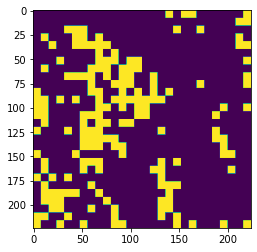

Saving heatmaps
D:/self_supervised_pathology/outputs/attention/dino_base/NCT-CRC-HE-100K-NONORM/LYM\attn-head0.png saved.
D:/self_supervised_pathology/outputs/attention/dino_base/NCT-CRC-HE-100K-NONORM/LYM\attn-head1.png saved.
D:/self_supervised_pathology/outputs/attention/dino_base/NCT-CRC-HE-100K-NONORM/LYM\attn-head2.png saved.
D:/self_supervised_pathology/outputs/attention/dino_base/NCT-CRC-HE-100K-NONORM/LYM\attn-head3.png saved.
D:/self_supervised_pathology/outputs/attention/dino_base/NCT-CRC-HE-100K-NONORM/LYM\attn-head4.png saved.
D:/self_supervised_pathology/outputs/attention/dino_base/NCT-CRC-HE-100K-NONORM/LYM\attn-head5.png saved.
displaying
D:/self_supervised_pathology/outputs/attention/dino_base/NCT-CRC-HE-100K-NONORM/LYM\mask_th0.5_head0.png saved.
D:/self_supervised_pathology/outputs/attention/dino_base/NCT-CRC-HE-100K-NONORM/LYM\mask_th0.5_head1.png saved.
D:/self_supervised_pathology/outputs/attention/dino_base/NCT-CRC-HE-100K-NONORM/LYM\mask_th0.5_head2.png saved.
D

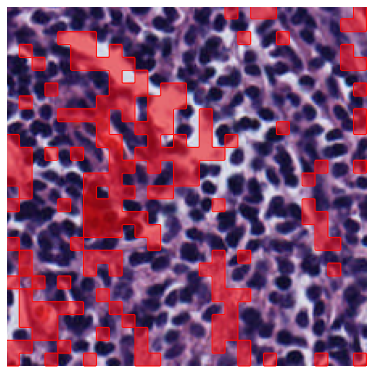

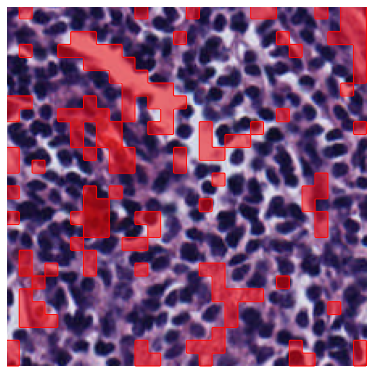

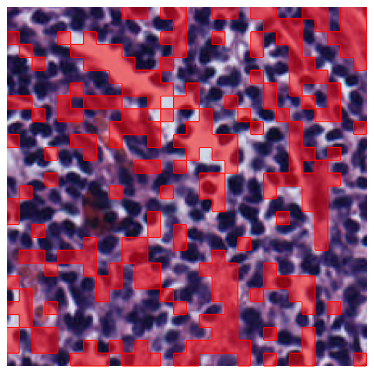

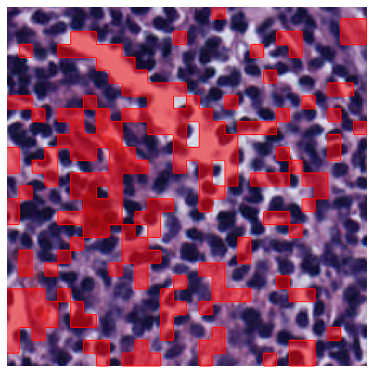

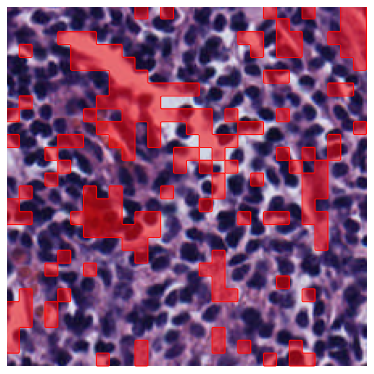

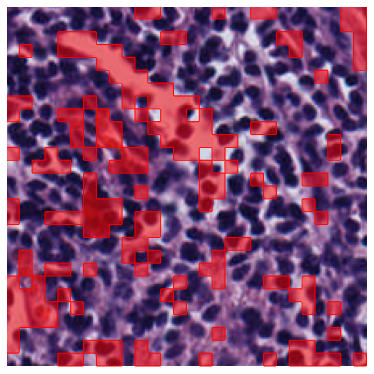

In [22]:
# open image
DATA_PATH = 'D:/self_supervised_pathology/datasets/NCT-CRC-HE-100K-NONORM/LYM'
OUT_PATH = 'D:/self_supervised_pathology/outputs/attention/dino_base/NCT-CRC-HE-100K-NONORM/LYM'

print('Making output dir')
os.makedirs(OUT_PATH, exist_ok=True)

# im_names = os.scandir(DATA_PATH)
image_size = 224
patch_size = 8
threshold = 0.5


# for im in im_names:
im = 'LYM-AAAEAEME.tif'
image_path = os.path.join(DATA_PATH, im)
print(f'handling {im}')
if os.path.isfile(image_path):

    img = imread(image_path)
else:
    print(f"Provided image path {image_path} is non valid.")
    raise RuntimeError

transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
    pth_transforms.Resize(image_size),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(img)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

print('computing attention')
attentions = model.get_last_selfattention(img.to(device))

nh = attentions.shape[1] # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

if threshold is not None:
    print('Thresholding')
    # we keep only a certain percentage of the mass
    val, idx = torch.sort(attentions)
    val /= torch.sum(val, dim=1, keepdim=True)
    cumval = torch.cumsum(val, dim=1)
    th_attn = cumval > (1 - threshold)
    idx2 = torch.argsort(idx)
    for head in range(nh):
        th_attn[head] = th_attn[head][idx2[head]]
    th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    # interpolate
    th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].detach().cpu().numpy()
    plt.imshow(th_attn[0])
    plt.show()

attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].detach().cpu().numpy()

# save attentions heatmaps
print('Saving heatmaps')
os.makedirs(OUT_PATH, exist_ok=True)
torchvision.utils.save_image(torchvision.utils.make_grid(img, normalize=True, scale_each=True), os.path.join(OUT_PATH, im))
for j in range(nh):
    fname = os.path.join(OUT_PATH, "attn-head" + str(j) + ".png")
    plt.imsave(fname=fname, arr=attentions[j], format='png')
    print(f"{fname} saved.")

if threshold is not None:
    print('displaying')
    image = imread(os.path.join(OUT_PATH, im))
    for j in range(nh):
        display_instances(image, th_attn[j], fname=os.path.join(OUT_PATH, "mask_th" + str(threshold) + "_head" + str(j) +".png"), blur=False)


In [ ]:
print((model.state_dict()['cls_token'][:10].cpu() == state_dict['teacher']['backbone.cls_token'][:10]).all())
